In [18]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
%matplotlib inline

Forty-four babies – a new record – were born in one 24-hour period at the Mater Mothers’ Hospital in Brisbane, Queensland, Australia, on December 18, 1997. For each of the 44 babies, The Sunday Mail recorded the time of birth, the sex of the child, and the birth weight in grams. Also included is the number of minutes since midnight for each birth.

Columns:
- 1 -  8  Time of birth recorded on the 24-hour clock
- 9 - 16  Sex of the child (1 = girl, 2 = boy)
- 17 - 24  Birth weight in grams
- 25 - 32  Number of minutes after midnight of each birth

In [11]:
df = pd.read_table("../data/babyboom.dat.txt", header=None, sep='\s+', 
                   names=['24hrtime','sex','weight','minutes'], dtype={'24hrtime': str})
df.head()

,24hrtime,sex,weight,minutes
0,0005,1,3837,5
1,0104,1,3334,64
2,0118,2,3554,78
3,0155,2,3838,115
4,0257,2,3625,177


In [15]:
# bin the number of births into hourly bins
df['minsbin'] = df.minutes // 60
df.head()

,24hrtime,sex,weight,minutes,minsbin
0,0005,1,3837,5,0
1,0104,1,3334,64,1
2,0118,2,3554,78,1
3,0155,2,3838,115,1
4,0257,2,3625,177,2


# Sample vs population

What is data? According to Frequentist statistics, data is a sample from an exsiting population.

Choosing a model: the exponetial distribution

$$f(x, \lambda) = \begin{cases} \lambda e^{-\lambda x} & x \geq 0 \\ 0 & x < 0\end{cases}$$

From Wikipedia: 
> In probability theory, a Poisson process is a stochastic process which counts the number of events and the time that these events occur in a given time interval. The time between each pair of consecutive events has an exponential distribution with parameter λ and each of these inter-arrival times is assumed to be independent of other inter-arrival times. The process is named after the French mathematician Siméon Denis Poisson and is a good model of radioactive decay, telephone calls and requests for a particular document on a web server, among many other phenomena.


In our example above, we have the arrival times of the babies. There is no reason to expect any specific clustering in time, so one could think of modelling the arrival of the babies via a poisson process.

Furthermore, the Poisson distribution can be used to model the number of births each hour over the 24-hour period.


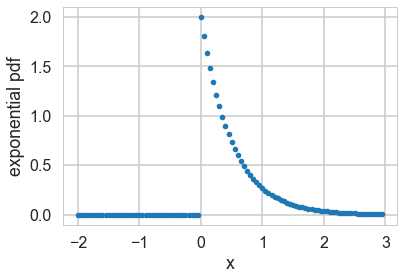

In [20]:
# own exponential function
f = lambda x, l: l*np.exp(-l*x)*(x>0)
xpts=np.arange(-2,3,0.05)
plt.plot(xpts,f(xpts, 2),'.');
plt.xlabel("x")
plt.ylabel("exponential pdf");

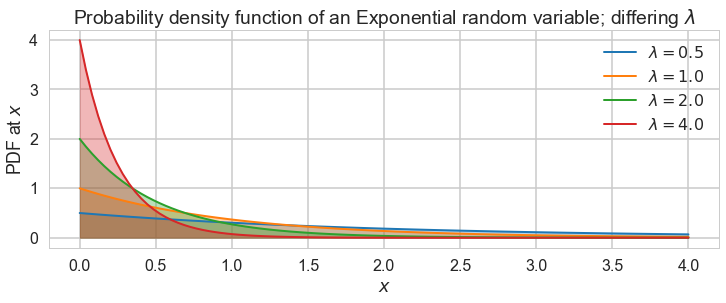

In [21]:
from scipy.stats import expon

x = np.linspace(0,4, 100)
colors=sns.color_palette()

lambda_ = [0.5, 1, 2, 4]
plt.figure(figsize=(12,4))
for l,c in zip(lambda_,colors):
    plt.plot(x, expon.pdf(x, scale=1./l), lw=2, 
                color=c, label = "$\lambda = %.1f$"%l)
    plt.fill_between(x, expon.pdf(x, scale=1./l), color=c, alpha = .33)
    
plt.legend()
plt.ylabel("PDF at $x$")
plt.xlabel("$x$")
plt.title("Probability density function of an Exponential random variable;\
 differing $\lambda$");


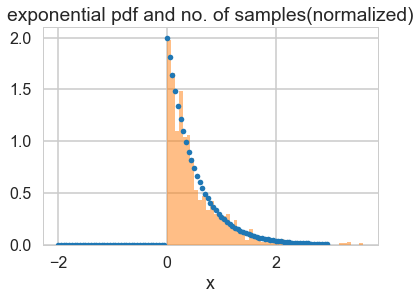

In [25]:
# draw from this distribution
from scipy.stats import expon
plt.plot(xpts,expon.pdf(xpts, scale=1./2.),'.')
plt.hist(expon.rvs(size=1000, scale=1./2.), normed=True, alpha=0.5, bins=50);
#if you remove normed=True you will get the actual number of samples
plt.xlabel("x")
plt.title("exponential pdf and no. of samples(normalized)");

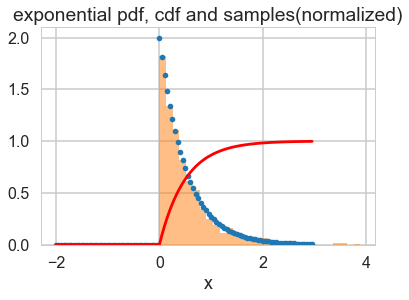

In [29]:
# using frozen distribution objects
rv = expon(scale=0.5)
plt.plot(xpts,rv.pdf(xpts),'.')
plt.hist(rv.rvs(size=1000), normed=True, alpha=0.5, bins=30);
plt.plot(xpts, rv.cdf(xpts), color='r');
plt.xlabel("x")
plt.title("exponential pdf, cdf and samples(normalized)");

# The Poisson distribution

The Poisson distribution is another discrete distribution, it expresses the probability of a given number of events occurring in a fixed interval of time (or space, volume, etc.). One assumption made is that these events occur with a known average rate and independently of each other. An example is the number of electrons detected by a sensor in an electron microscope during a time interval, or the number of soldiers in the Prussian army killed accidentally by horse kicks 

The Poisson distribtion is defined as: $$f(k,\mu) = \frac{\mu^k e^{-\mu}}{k!}$$, $k$ is the number of events, $\mu$ is a postive real number (the rate?), and $e$ is Euler's number.

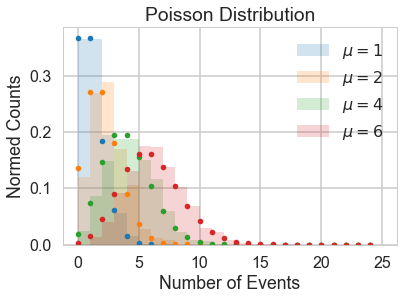

In [35]:
from scipy.stats import poisson
# generate samples for different values of mu
kpts=np.arange(0,25)
for mu, c in zip([1,2, 4, 6], sns.color_palette()[:4]):
    randomVariates = poisson.rvs(mu, size=1000)
    plt.hist(randomVariates, normed=True, color=c, alpha=0.2, bins=range(0,26), label='$\mu=' + np.str(mu) + '$')
    plt.plot(kpts, poisson.pmf(kpts, mu), '.', color=c)

plt.legend()
plt.title("Poisson Distribution")
plt.xlabel("Number of Events")
plt.ylabel("Normed Counts");

# Understanding birth data

Lets play with our data a bit to understand it:
The first birth occurred at 0005, and the last birth in the 24-hour period at 2355. Thus the 43 inter-birth times happened over a 1430-minute period, giving a theoretical mean of 1430/43 = 33.26 minutes between births.
Lets plot a histogram of the inter-birth times

33.25581395348837


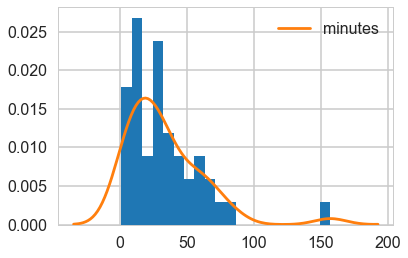

In [78]:
timediffs = df.minutes.diff()[1:]
print(timediffs.mean())
timediffs.hist(bins=20, normed=True)
sns.kdeplot(timediffs)

The exponential distribution is a continuous distribution and has a pdf. The default normed=True option for histograms in matplotlib aims to give us a normalized density by setting the area of the histogram to 1. We can play with the number of bins: this is a bit of an art. Too few and you under-represent variability/ Too many and you overfit to it. Play to see what works for you. I will sometimes use sns.kdeplot and try and adjust bins to match.m

Now we do the same for poisson distribution. How many births happen in one hour (over 24 hour)?

In [80]:
poiskcount = df.groupby('minsbin')['minutes'].count()
poiskcount

minsbin
0     1
1     3
2     1
4     4
7     2
8     2
9     1
10    3
11    1
12    2
13    1
14    4
15    1
16    2
17    1
18    3
19    4
20    3
21    2
22    1
23    2
Name: minutes, dtype: int64

Since the Poisson is a discrete distribution, it has a probability mass function. Normalizing a pdf is not what we want here, rather, the values of the pmf (which are probabilities) should sum to 1. So we take matters into our own hands.

We make sure that every point has equal mass, so that the total mass is one. Then the mass at any point depends on how many samples (the count) we have for it.

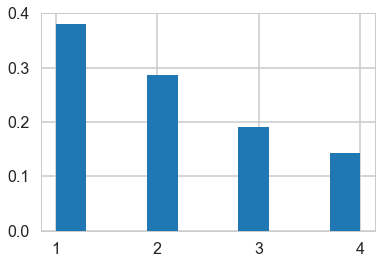

In [86]:
weights = np.ones_like(poiskcount)/len(poiskcount)
poiskcount.hist(weights=weights)

# Maximum likelihood estimation
This is a common technique for estimating parameters in frequentist statistics. 

For inter-birth time distribution, we assume its pdf follows a exponential distribution. We want to find out which $\lambda$, i.e., we fit an exponetial distribution using data. 

Using MLE: $\frac{1}{\lambda_{MLE}} = \frac{1}{n}\sum_{i=1}^{n}x_i$

This makes intuitive sense: if you get babies at an average rate of 2 per hour, then you can expect to wait half an hour on average for every baby.

In [88]:
lambda_from_mean = 1./timediffs.mean()
print(lambda_from_mean, 1./lambda_from_mean)

0.03006993006993007 33.25581395348837


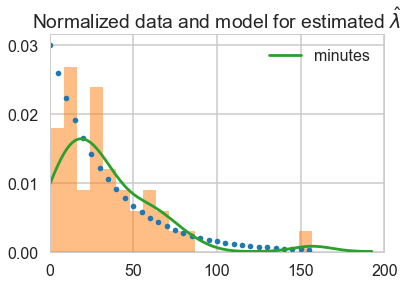

In [92]:
minutes=np.arange(0, 160, 5)
rv = expon(scale=1./lambda_from_mean)
plt.plot(minutes,rv.pdf(minutes),'.')
timediffs.hist(normed=True, alpha=0.5, bins=20);
sns.kdeplot(timediffs)
plt.xlim([0,200])
plt.title("Normalized data and model for estimated $\hat{\lambda}$");


What did we just do? We made a ‘point estimate’ of the scale or rate parameter as a compression of our data.

# For Poisson

MLE estimation for Poisson is $$\mu_{MLE} = \frac{1}{n}\sum_{i=1}^{n}k_i$$

In [94]:
mumle = np.mean(poiskcount)
mumle

2.0952380952380953

In [96]:
np.var(poiskcount) # note that mean != var not a great poisson.

1.1337868480725624

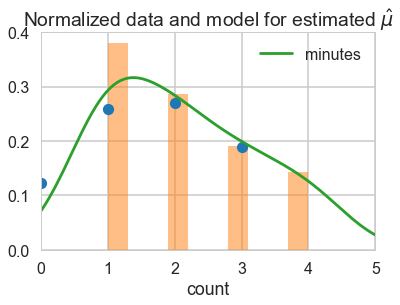

In [97]:
counts=np.arange(0, 4, 1)
poisrv = poisson(mumle)
plt.plot(counts,poisrv.pmf(counts),'o')
poiskcount.hist(weights=weights, alpha=0.5);
sns.kdeplot(poiskcount)
plt.xlabel("count");
plt.xlim([0,5])
plt.title("Normalized data and model for estimated $\hat{\mu}$");

# Frequentist statistics

In frequentist statistics, the data we have in hand, is viewed as a sample from a population. So if we want to estimate some parameter of the population, like say the mean, we estimate it on the sample.
This is because we’ve been given only one sample. Ideally we’d want to see the population, but we have no such luck.
The parameter estimate is computed by applying an estimator F
F
 to some data D
D
, so λ̂ =F(D)
λ
^
=
F
(
D
)
.
**The parameter is viewed as fixed and the data as random, which is the exact opposite of the Bayesian approach which you will learn later in this class. **
For the babies, lets assume that an exponential distribution is a good description of the baby arrival process. Then we consider some larger population of babies from which this sample is drawn, there is some true λ∗
λ
∗
 which defines it. We dont know this. The best we can do to start with is to estimate a lambda from the data set we have, which we denote λ̂ 
λ
^
.
Now, imagine that I let you peek at the entire population in this way: I gave you some M data sets drawn from the population, and you can now find the mean on each such dataset, of which the one we have here is one. So, we’d have M means. You can think of these means as coming from some fixed parameter by some data drawing process
Thus if we had many replications of this data set: that is, data from other days, an ensemble of data sets, for example, we can compute other λ̂ 
λ
^
, and begin to construct the sampling distribution of λ
λ
.
But we dont.

# Sampling distribution of the rate

So, in the babies case, the uncertainty in the parameter estimate can be measured by computing the sampling distribution of the estimator. What you are doing is sampling many Data Sets Di
D
i
 from the true population (which we are not given you will argue, and you are right, but just wait a bit), say M of them, each of size N, from some true model p(⋅|λ∗)
p
(
⋅
|
λ
∗
)
. We will now calculate M λ̂ i
λ
^
i
, one for each dataset. As we let M→∞
M
→
∞
, the distribution induced on λ̂ 
λ
^
 is the sampling distribution of the estimator.
We can use the sampling distribution to put confidence intervals on the estimation of the parameters.

# Bootstrap

Bootstrap tries to approximate our sampling distribution. If we knew the true parameters of the population, we could generate M fake datasets. Then we could compute the parameter (or another estimator) on each one of these, to get a empirical sampling distribution of the parameter or estimator, and which will give us an idea of how typical our sample is, and thus, how good our parameter estimations from our sample are. (again from murphy)
But we dont have the true parameter. So we generate these samples, using the parameter we calculated. Or, alteratively, we sample with replacement the X from our original sample D, generating many fake datasets, and then compute the distribution on the parameters as before.
We do it here for the mean of the time differences. We could also do it for its inverse, λ
λ
.

## Non Parametric

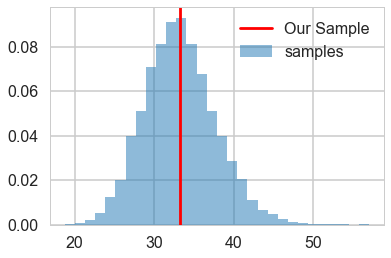

In [110]:
M_samples=10000
N_points = timediffs.shape[0]
bs_np = np.random.choice(timediffs, size=(M_samples, N_points), replace=True)
sd_mean=np.mean(bs_np, axis=1)
sd_std=np.std(bs_np, axis=1)
plt.hist(sd_mean, bins=30, normed=True, alpha=0.5,label="samples");
plt.axvline(timediffs.mean(), 0, 1, color='r', label='Our Sample')
plt.legend()

## Parametric

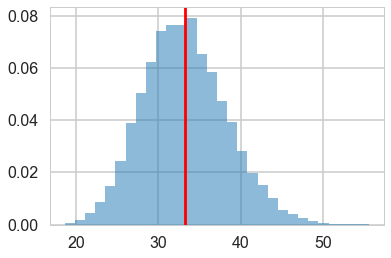

In [113]:
# fit model using original data 
rv = expon(scale=1./lambda_from_mean)

# make M simulated data sets from fit model
M_samples=10000
N_points = timediffs.shape[0]
bs_p = rv.rvs(size=(M_samples, N_points))
sd_mean_p=np.mean(bs_p, axis=1)
sd_std_p=np.std(bs_p, axis=1)
plt.hist(sd_mean_p, bins=30, normed=True, alpha=0.5);
plt.axvline(timediffs.mean(), 0, 1, color='r', label='Our Sample')